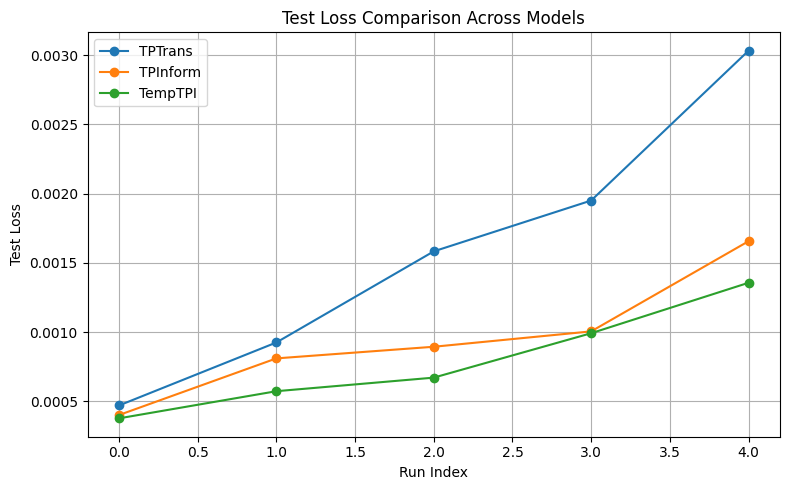

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results_large_data.csv")

# Create a plot
plt.figure(figsize=(8,5))

for model in df["model"].unique():
    subset = df[df["model"] == model].reset_index(drop=True)
    plt.plot(subset.index, subset["test_loss"], marker="o", label=model)

plt.xlabel("Run Index")
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()